In [19]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import imageio.v3 as iio
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 
from torchvision.transforms import v2

from data.imagenette import ImagenetteClassification
#%matplotlib widget
#plt.rcParams["text.usetex"] = True
plt.rcParams["axes.grid"] = True

In [20]:
ROOT = Path.home() / "datasets" / "imagenette"
REPORT = Path.home() / "experiments" / "imagenette-classification" / "test_run"
INCORRECT_SAMPLES = sorted((REPORT / "performance_report").glob("*incorrect_samples.csv"))
display(INCORRECT_SAMPLES)

df = (
    pd.read_csv(REPORT / "dataset.csv", index_col = 0)
    .assign(image_path = lambda df: df["image_path"].apply(lambda x: ROOT / x))
    .join(other = pd.read_csv(INCORRECT_SAMPLES[-1], index_col = 0).set_index("idx"), how = "inner")
    .reset_index(drop = True)

)
display(df)

[PosixPath('/home/sambhav/experiments/imagenette-classification/test_run/performance_report/step=0-epoch=0-val-incorrect_samples.csv'),
 PosixPath('/home/sambhav/experiments/imagenette-classification/test_run/performance_report/step=252-epoch=0-val-incorrect_samples.csv'),
 PosixPath('/home/sambhav/experiments/imagenette-classification/test_run/performance_report/step=504-epoch=1-val-incorrect_samples.csv'),
 PosixPath('/home/sambhav/experiments/imagenette-classification/test_run/performance_report/step=756-epoch=2-val-incorrect_samples.csv')]

,image_path,label_str,label_idx,split,preds
0,/home/sambhav/datasets/imagenette/train/n02979...,cassette_player,0,val,"[5.778636455535889, -1.6317297220230103, 0.712..."
1,/home/sambhav/datasets/imagenette/train/n02979...,cassette_player,0,val,"[2.927121162414551, 0.8498141169548035, -0.839..."
2,/home/sambhav/datasets/imagenette/train/n02979...,cassette_player,0,val,"[0.4736694097518921, 0.7706112861633301, -4.04..."
3,/home/sambhav/datasets/imagenette/val/n0297918...,cassette_player,0,val,"[0.7247865200042725, -0.7578983306884766, -2.9..."
4,/home/sambhav/datasets/imagenette/train/n02979...,cassette_player,0,val,"[4.3564887046813965, -4.19417142868042, 0.6902..."
...,...,...,...,...,...
177,/home/sambhav/datasets/imagenette/val/n0388825...,parachute,8,val,"[-2.350945234298706, 0.9905006885528564, 2.967..."
178,/home/sambhav/datasets/imagenette/train/n03888...,parachute,8,val,"[-0.16777347028255463, -1.0865964889526367, -2..."
179,/home/sambhav/datasets/imagenette/train/n01440...,tench,9,val,"[-3.005295991897583, -0.6953651905059814, 0.16..."
180,/home/sambhav/datasets/imagenette/train/n01440...,tench,9,val,"[-3.758000612258911, 3.808250904083252, -4.945..."


In [21]:
image_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale = True),
    v2.Resize((256, 256), antialias=False)
])

sample = df.iloc[np.random.randint(0, len(df))]
sample_image = image_transform(iio.imread(sample["image_path"])).numpy().transpose(1,2,0)
sample_attribution = np.random.standard_normal(sample_image.shape)
sample_preds = torch.softmax(
    torch.tensor([float(p) for p in sample["preds"].removeprefix('[').removesuffix(']').split(", ")], dtype = torch.float32),
    dim = 0
)
sample_class_idxs = list(range(len(sample_preds)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


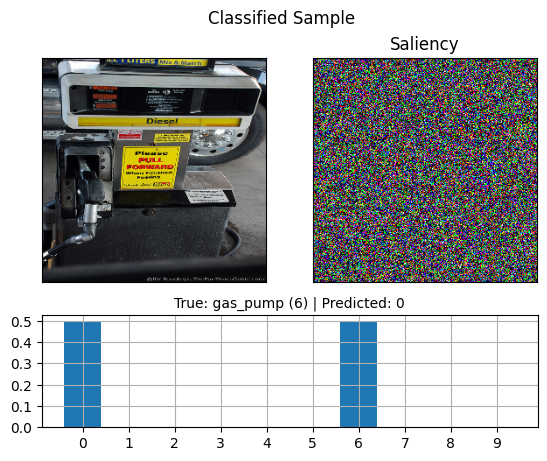

In [22]:
fig = plt.figure()
fig.suptitle(f"Classified Sample")

gs = GridSpec(nrows = 2, ncols = 2, height_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax1.imshow(sample_image)
ax1.set(**{
    "xticks": [],
    "yticks": [],
})


ax2 = fig.add_subplot(gs[1])
ax2.imshow(sample_attribution)
ax2.set(**{
    "xticks": [],
    "yticks": [],
    "title": "Saliency"
})


ax3 = fig.add_subplot(gs[2:])
ax3.bar(x = sample_class_idxs, height = sample_preds)

#TODO: get predicted name from Dataset.CLASS_NAMES[sample['label_idx']]
ax3.set_title(f"True: {sample['label_str']} ({sample['label_idx']}) | Predicted: {torch.argmax(sample_preds, 0).item()}", fontsize = 10)
ax3.set_xticks(sample_class_idxs)
ax3.set_yticks(np.arange(0, sample_preds.max(), .1))
ax3.autoscale(True, axis = 'y')

In [44]:
num_classes = 10
incorrect_samples = {
    "idx": np.random.randint(0, 10, (10,)).tolist(),
    "preds": np.random.standard_normal((10, 10)).tolist(),
}

def __create_samples_df(samples: dict[str, list], num_classes: int) -> pd.DataFrame:
    class_names = [f"class_{c}" for c in range(num_classes)]
    df = pd.DataFrame(columns = ["idx", *class_names])
    for idx, pred in zip(incorrect_samples["idx"], incorrect_samples["preds"]):
        df.loc[len(df.index)] = [idx, *pred]
    df["idx"] = df["idx"].astype(np.uint32)
    return df
